In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.decomposition import PCA

<h2>Создание датасета для кластеризации</h2>

In [2]:
# Создаем синтетические данные, представляющие разные классы звуков
np.random.seed(42)
n_samples = 300

# Кластер 1: Гласные переднего ряда верхнего подъема /i/, /y/
vowels_front_close = {
    'f1': np.random.normal(240, 30, n_samples // 3),
    'f2': np.random.normal(2250, 200, n_samples // 3),
    'duration': np.random.normal(120, 15, n_samples//3),
    'intensity': np.random.normal(75, 5, n_samples//3)
}

# Кластер 2: Гласные заднего ряда [u, o]
vowels_close_back = {
    'f1': np.random.normal(300, 50, n_samples//3),
    'f2': np.random.normal(620, 50, n_samples//3),
    'duration': np.random.normal(120, 20, n_samples//3),
    'intensity': np.random.normal(78, 4, n_samples//3)
}

# Кластер 3: Гласные нижнего подъема [ɑ, ɒ]
vowels_open_back = {
    'f1': np.random.normal(720, 40, n_samples//3),
    'f2': np.random.normal(800, 200, n_samples//3),
    'duration': np.random.normal(120, 12, n_samples//3),
    'intensity': np.random.normal(79, 8, n_samples//3)
}

# Объединяем данные
data = {
    'f1': np.concatenate([vowels_front_close['f1'], vowels_close_back['f1'], vowels_open_back['f1']]),
    'f2': np.concatenate([vowels_front_close['f2'], vowels_close_back['f2'], vowels_open_back['f2']]),
    'duration': np.concatenate([vowels_front_close['duration'], vowels_close_back['duration'], vowels_open_back['duration']]),
    'intensity': np.concatenate([vowels_front_close['intensity'], vowels_close_back['intensity'], vowels_open_back['intensity']])
}

# Истинные метки для оценки
true_labels = np.concatenate([
    np.zeros(n_samples // 3),
    np.ones(n_samples // 3),
    np.full(n_samples // 3, 2)
])

# Создаем DataFrame
df = pd.DataFrame(data)
df['true_class'] = true_labels
df['true_class_name'] = df['true_class'].map({0: 'передние_вп', 1: 'задние_вп', 2: 'задние_нп'})

print("Датасет для кластеризации:")
print(df.head())
print(f"\nРазмер датасета: {df.shape}")
print(f"\nРаспределение истинных классов:")
print(df['true_class_name'].value_counts())

Датасет для кластеризации:
           f1           f2    duration  intensity  true_class true_class_name
0  254.901425  1966.925852  125.366810  70.855025         0.0     передние_вп
1  235.852071  2165.870935  128.411768  72.199095         0.0     передние_вп
2  259.430656  2181.457097  136.245769  78.736468         0.0     передние_вп
3  285.690896  2089.544546  135.807031  78.051851         0.0     передние_вп
4  232.975399  2217.742858   99.334959  74.895492         0.0     передние_вп

Размер датасета: (300, 6)

Распределение истинных классов:
true_class_name
передние_вп    100
задние_вп      100
задние_нп      100
Name: count, dtype: int64


<h2>Визуализация исходных данных</h2>

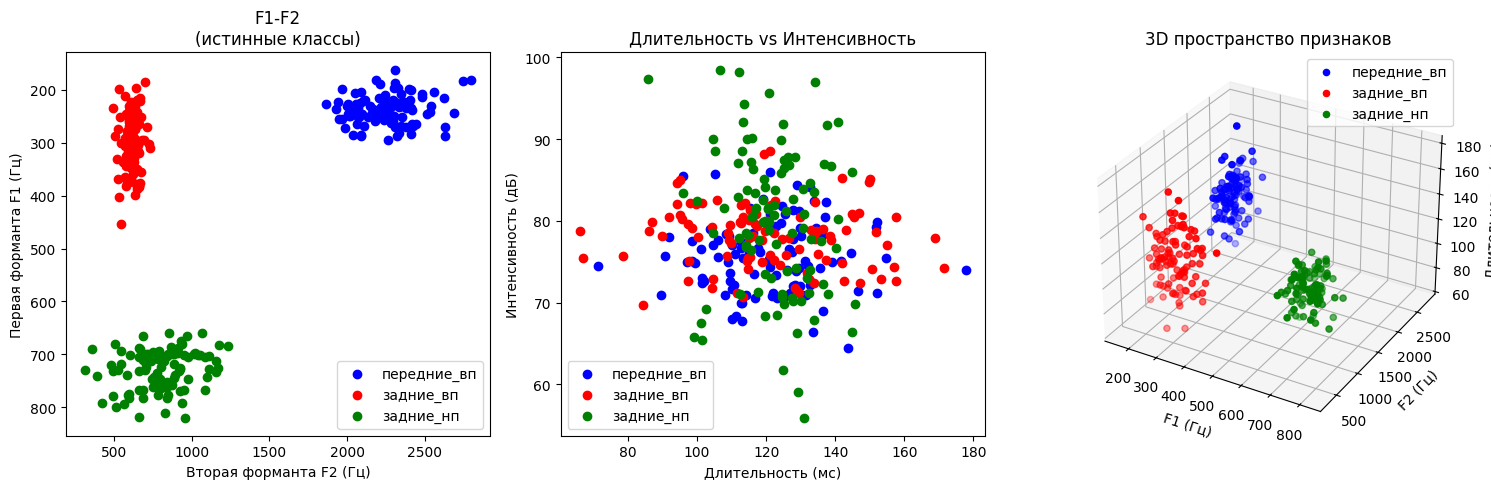

In [3]:
fig = plt.figure(figsize=(15, 5))

# F1 vs F2
plt.subplot(1, 3, 1)
colors = ['blue', 'red', 'green']
for i, class_name in enumerate(['передние_вп', 'задние_вп', 'задние_нп']):
    class_data = df[df['true_class_name'] == class_name]
    plt.scatter(class_data['f2'], class_data['f1'],
                c=colors[i], label=class_name)
plt.xlabel('Вторая форманта F2 (Гц)')
plt.ylabel('Первая форманта F1 (Гц)')
plt.title('F1-F2\n(истинные классы)')
plt.legend()
plt.gca().invert_yaxis()  # Инвертируем ось Y как в традиционных фонетических графиках

# Длительность vs Интенсивность
plt.subplot(1, 3, 2)
for i, class_name in enumerate(['передние_вп', 'задние_вп', 'задние_нп']):
    class_data = df[df['true_class_name'] == class_name]
    plt.scatter(class_data['duration'], class_data['intensity'],
                c=colors[i], label=class_name)
plt.xlabel('Длительность (мс)')
plt.ylabel('Интенсивность (дБ)')
plt.title('Длительность vs Интенсивность')
plt.legend()

# 3D визуализация
from mpl_toolkits.mplot3d import Axes3D
ax = fig.add_subplot(1, 3, 3, projection='3d')
for i, class_name in enumerate(['передние_вп', 'задние_вп', 'задние_нп']):
    class_data = df[df['true_class_name'] == class_name]
    ax.scatter(class_data['f1'], class_data['f2'], class_data['duration'],
               c=colors[i], label=class_name)
ax.set_xlabel('F1 (Гц)')
ax.set_ylabel('F2 (Гц)')
ax.set_zlabel('Длительность (мс)')
ax.set_title('3D пространство признаков')
ax.legend()

plt.tight_layout()
plt.show()

<h2>Подготовка данных для кластеризации</h2>

In [4]:
# Выделяем признаки для кластеризации (посмотрим каким будет оптимальный k при различных наборах признаков)
X = df[['f1', 'f2', 'duration', 'intensity']]

print("Признаки для кластеризации:")
print(X.columns.tolist())
print(f"\nСтатистика признаков:")
print(X.describe())

# Масштабируем данные (важно для K-средних!)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Создаем DataFrame с масштабированными данными
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)
print(f"\nМасштабированные данные (первые 5 строк):")
print(X_scaled_df.head().round(3))

Признаки для кластеризации:
['f1', 'f2', 'duration', 'intensity']

Статистика признаков:
               f1           f2    duration   intensity
count  300.000000   300.000000  300.000000  300.000000
mean   421.076781  1224.755467  121.125805   77.788764
std    223.311340   750.480646   16.788150    6.379565
min    161.407647   315.224135   66.062267   55.829957
25%    243.657841   624.141695  112.122368   73.483264
50%    296.217195   817.454096  121.080765   77.785886
75%    699.298777  2087.514594  131.680139   81.271071
max    821.077297  2794.033833  177.790972   98.518019

Масштабированные данные (первые 5 строк):
      f1     f2  duration  intensity
0 -0.745  0.991     0.253     -1.089
1 -0.831  1.256     0.435     -0.878
2 -0.725  1.277     0.902      0.149
3 -0.607  1.154     0.876      0.041
4 -0.844  1.325    -1.300     -0.454


<h2>Метод локтя для определения оптимального k</h2>

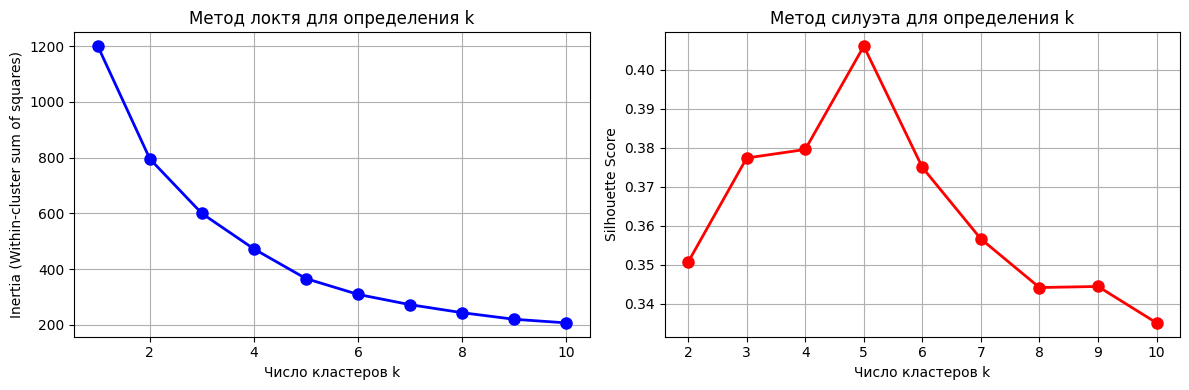

Анализ оптимального k:
Рекомендуемое k по методу силуэта: 5


In [5]:
# Метод локтя для определения оптимального числа кластеров
inertia = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Метод силуэта для дополнительной проверки
silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_scaled)
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Визуализация
plt.figure(figsize=(12, 4))

# Метод локтя
plt.subplot(1, 2, 1)
plt.plot(k_range, inertia, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Число кластеров k')
plt.ylabel('Inertia (Within-cluster sum of squares)')
plt.title('Метод локтя для определения k')
plt.grid(True)

# Метод силуэта
plt.subplot(1, 2, 2)
plt.plot(range(2, 11), silhouette_scores, 'ro-', linewidth=2, markersize=8)
plt.xlabel('Число кластеров k')
plt.ylabel('Silhouette Score')
plt.title('Метод силуэта для определения k')
plt.grid(True)

plt.tight_layout()
plt.show()

print("Анализ оптимального k:")
print(f"Рекомендуемое k по методу силуэта: {np.argmax(silhouette_scores) + 2}")

<h2>Кластеризация K-средних с оптимальным k (k=3)</h2>

In [6]:
optimal_k = 3

# Обучаем K-средних
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_scaled)

# Добавляем метки кластеров в DataFrame
df['cluster'] = cluster_labels
df['cluster_name'] = df['cluster'].map({0: 'Кластер_0', 1: 'Кластер_1', 2: 'Кластер_2'})

print("Результаты кластеризации:")
print(f"Центры кластеров (в масштабированных координатах):")
centers_scaled = kmeans.cluster_centers_
print(centers_scaled)

# Преобразуем центры обратно в исходные координаты
centers_original = scaler.inverse_transform(centers_scaled)
centers_df = pd.DataFrame(centers_original, columns=X.columns)
print(f"\n Центры кластеров (в исходных координатах):")
print(centers_df.round(1))

Результаты кластеризации:
Центры кластеров (в масштабированных координатах):
[[-0.55565465 -0.81486556 -0.03842015  0.02929756]
 [ 1.38185511 -0.55948824  0.04751082  0.3246968 ]
 [-0.82620047  1.3743538  -0.00909066 -0.35399437]]

 Центры кластеров (в исходных координатах):
      f1      f2  duration  intensity
0  297.2   614.2     120.5       78.0
1  729.1   805.6     121.9       79.9
2  236.9  2254.5     121.0       75.5


<h2>Визуализация результатов кластеризации</h2>

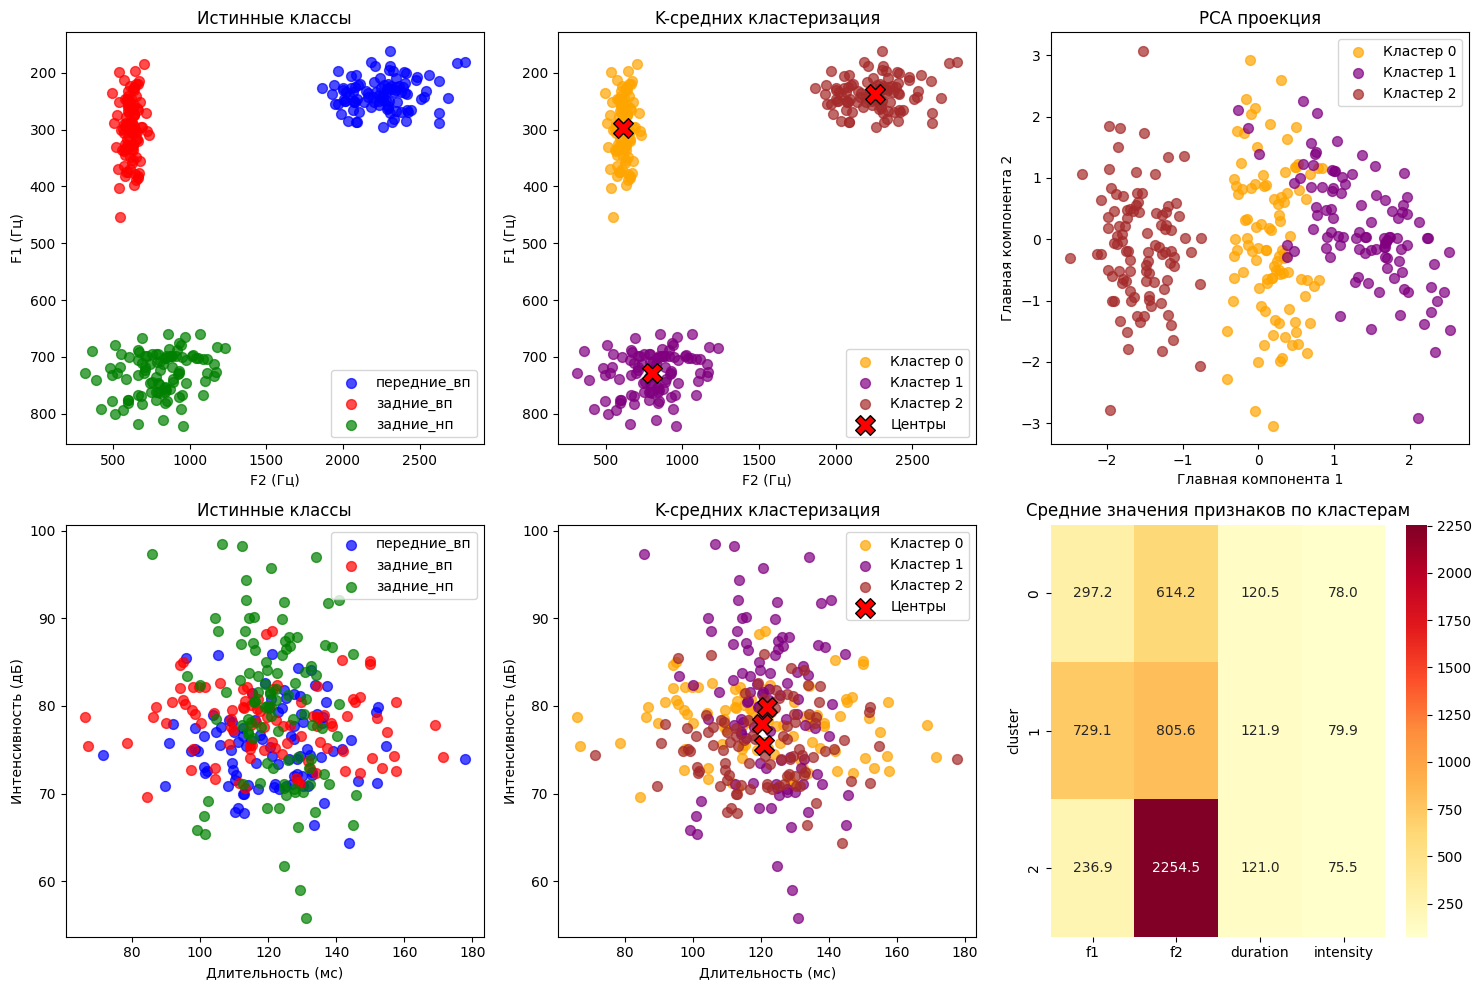

In [7]:
# Визуализация результатов кластеризации
fig = plt.figure(figsize=(15, 10))

# F1 vs F2 - сравнение истинных и предсказанных кластеров
plt.subplot(2, 3, 1)
for i, class_name in enumerate(['передние_вп', 'задние_вп', 'задние_нп']):
    class_data = df[df['true_class_name'] == class_name]
    plt.scatter(class_data['f2'], class_data['f1'],
                c=colors[i], label=class_name, alpha=0.7, s=50)
plt.xlabel('F2 (Гц)')
plt.ylabel('F1 (Гц)')
plt.title('Истинные классы')
plt.legend()
plt.gca().invert_yaxis()

plt.subplot(2, 3, 2)
cluster_colors = ['orange', 'purple', 'brown']
for i in range(optimal_k):
    cluster_data = df[df['cluster'] == i]
    plt.scatter(cluster_data['f2'], cluster_data['f1'],
                c=cluster_colors[i], label=f'Кластер {i}', alpha=0.7, s=50)
# Отмечаем центры кластеров
plt.scatter(centers_df['f2'], centers_df['f1'],
            c='red', marker='X', s=200, label='Центры', edgecolors='black')
plt.xlabel('F2 (Гц)')
plt.ylabel('F1 (Гц)')
plt.title('K-средних кластеризация')
plt.legend()
plt.gca().invert_yaxis()

# Длительность vs Интенсивность
plt.subplot(2, 3, 4)
for i, class_name in enumerate(['передние_вп', 'задние_вп', 'задние_нп']):
    class_data = df[df['true_class_name'] == class_name]
    plt.scatter(class_data['duration'], class_data['intensity'],
                c=colors[i], label=class_name, alpha=0.7, s=50)
plt.xlabel('Длительность (мс)')
plt.ylabel('Интенсивность (дБ)')
plt.title('Истинные классы')
plt.legend()

plt.subplot(2, 3, 5)
for i in range(optimal_k):
    cluster_data = df[df['cluster'] == i]
    plt.scatter(cluster_data['duration'], cluster_data['intensity'],
                c=cluster_colors[i], label=f'Кластер {i}', alpha=0.7, s=50)
plt.scatter(centers_df['duration'], centers_df['intensity'],
            c='red', marker='X', s=200, label='Центры', edgecolors='black')
plt.xlabel('Длительность (мс)')
plt.ylabel('Интенсивность (дБ)')
plt.title('K-средних кластеризация')
plt.legend()

# PCA для визуализации в 2D
plt.subplot(2, 3, 3)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

for i in range(optimal_k):
    cluster_data = X_pca[df['cluster'] == i]
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1],
                c=cluster_colors[i], label=f'Кластер {i}', alpha=0.7, s=50)
plt.xlabel('Главная компонента 1')
plt.ylabel('Главная компонента 2')
plt.title('PCA проекция')
plt.legend()

plt.subplot(2, 3, 6)
# Сравнение распределений по кластерам
cluster_stats = df.groupby('cluster')[['f1', 'f2', 'duration', 'intensity']].mean()
sns.heatmap(cluster_stats, annot=True, cmap='YlOrRd', fmt='.1f')
plt.title('Средние значения признаков по кластерам')

plt.tight_layout()
plt.show()

<h2>Оценка качества кластеризации</h2>

In [8]:
# Метрики оценки кластеризации
silhouette_avg = silhouette_score(X_scaled, cluster_labels)

print("ОЦЕНКА КАЧЕСТВА КЛАСТЕРИЗАЦИИ")
print(f"Silhouette Score: {silhouette_avg:.3f}")

# Сравнение с истинными метками (только для оценки, в реальных данных истинных меток нет)
if 'true_class' in df.columns:
    ari = adjusted_rand_score(df['true_class'], df['cluster'])
    print(f"Adjusted Rand Index: {ari:.3f}")

# Анализ распределения истинных классов по кластерам
cross_tab = pd.crosstab(df['cluster_name'], df['true_class_name'])
print("\nРаспределение истинных классов по кластерам:")
print(cross_tab)

ОЦЕНКА КАЧЕСТВА КЛАСТЕРИЗАЦИИ
Silhouette Score: 0.377
Adjusted Rand Index: 1.000

Распределение истинных классов по кластерам:
true_class_name  задние_вп  задние_нп  передние_вп
cluster_name                                      
Кластер_0              100          0            0
Кластер_1                0        100            0
Кластер_2                0          0          100


<h2>Применение модели к новым данным</h2>

In [9]:
def cluster_new_sound(f1, f2, duration, intensity, kmeans_model, scaler):
    """
    Кластеризация нового звука
    """
    # Создаем массив с признаками
    new_sound = np.array([[f1, f2, duration, intensity]])

    # Масштабируем
    new_sound_scaled = scaler.transform(new_sound)

    # Предсказываем кластер
    cluster = kmeans_model.predict(new_sound_scaled)[0]
    distances = kmeans_model.transform(new_sound_scaled)[0]

    return cluster, distances

# Примеры кластеризации новых звуков
cluster1, distances1 = cluster_new_sound(380, 2300, 110, 72, kmeans, scaler)
print(f"Звук (F1=380, F2=2300): отнесен к кластеру {cluster1}")

cluster2, distances2 = cluster_new_sound(720, 1050, 150, 80, kmeans, scaler)
print(f"Звук (F1=720, F2=1050): отнесен к кластеру {cluster2}")

cluster3, distances3 = cluster_new_sound(280, 1900, 70, 60, kmeans, scaler)
print(f"Звук (F1=280, F2=1900): отнесен к кластеру {cluster3}")

cluster4, distances4 = cluster_new_sound(500, 1600, 100, 70, kmeans, scaler)
print(f"Звук (F1=500, F2=1600): отнесен к кластеру {cluster4}")

Звук (F1=380, F2=2300): отнесен к кластеру 2
Звук (F1=720, F2=1050): отнесен к кластеру 1
Звук (F1=280, F2=1900): отнесен к кластеру 2
Звук (F1=500, F2=1600): отнесен к кластеру 2


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
